In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from mGPT.data.webui import HumanML3DDataModule
from mGPT.config import parse_args, get_module_config
from omegaconf import OmegaConf
from os.path import join as pjoin
import moviepy.editor as mp

In [3]:
# Load the assets config
cfg_assets = OmegaConf.load('configs/assets.yaml')

# Load the base config from the correct path
cfg_base = OmegaConf.load(pjoin(cfg_assets.CONFIG_FOLDER, 'default.yaml'))

# Merge the configs
cfg = OmegaConf.merge(cfg_base, cfg_assets)

# Register the eval resolver (needed for some config values)
OmegaConf.register_new_resolver("eval", eval)

# Load the full config with all module configs
if not cfg.get('FULL_CONFIG', False):
    print("Loading full config...")
    cfg = get_module_config(cfg, cfg_assets.CONFIG_FOLDER)

# Add missing TRAIN.STAGE key
if not hasattr(cfg.TRAIN, 'STAGE'):
    cfg.TRAIN.STAGE = 'text2motion'  # or whatever default value is appropriate

# Check if the key exists now
print("TRAIN.STAGE exists:", hasattr(cfg.TRAIN, 'STAGE'))
print("TRAIN.STAGE value:", cfg.TRAIN.STAGE)

# Now you can use this config to initialize your data module
datamodule = HumanML3DDataModule(cfg)

Loading full config...
TRAIN.STAGE exists: True
TRAIN.STAGE value: text2motion


Loaded motion features with shape: (179, 263)
Motion tensor shape: torch.Size([1, 179, 263])
Converted to joints with shape: torch.Size([1, 179, 22, 3])


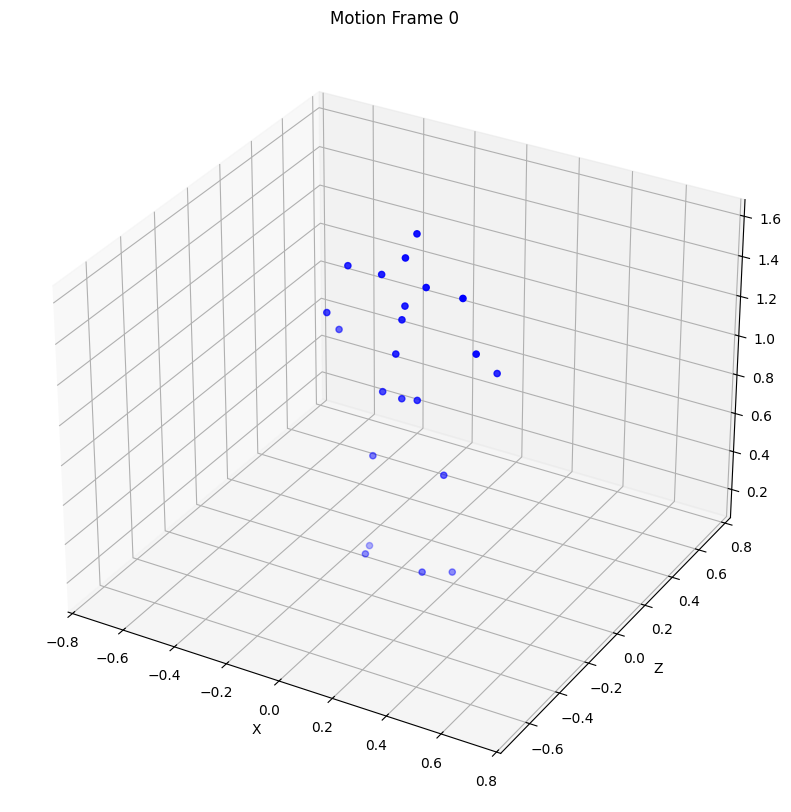

In [4]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Path to the HumanML3D dataset
data_path = "/workspace/HumanML3D"

# Load a sample motion feature file
sample_file = os.path.join(data_path, 'new_joint_vecs', '000021.npy')
motion_features = np.load(sample_file)
print(f"Loaded motion features with shape: {motion_features.shape}")

# Convert to tensor for processing
motion_tensor = torch.tensor(motion_features).float()

# Add batch dimension if needed
if len(motion_tensor.shape) == 2:
    motion_tensor = motion_tensor.unsqueeze(0)
    
print(f"Motion tensor shape: {motion_tensor.shape}")

# Convert features to joints using the datamodule's method
joints = datamodule.feats2joints(motion_tensor)
print(f"Converted to joints with shape: {joints.shape}")

# Visualize a frame of the motion
def visualize_frame(joints_data, frame_idx=0):
    """Visualize a single frame of the motion"""
    # Extract the frame
    frame = joints_data[0, frame_idx].cpu().numpy()
    
    # Create 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the joints
    ax.scatter(frame[:, 0], frame[:, 2], frame[:, 1], c='b', marker='o')
    
    # Set labels and limits
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    
    # Set equal aspect ratio
    max_range = np.array([frame[:, 0].max() - frame[:, 0].min(),
                          frame[:, 1].max() - frame[:, 1].min(),
                          frame[:, 2].max() - frame[:, 2].min()]).max() / 2.0
    mid_x = (frame[:, 0].max() + frame[:, 0].min()) * 0.5
    mid_y = (frame[:, 1].max() + frame[:, 1].min()) * 0.5
    mid_z = (frame[:, 2].max() + frame[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    
    plt.title(f"Motion Frame {frame_idx}")
    plt.show()

# Visualize the first frame
if joints.shape[1] > 0:
    visualize_frame(joints, frame_idx=0)


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import io
import matplotlib
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.axes3d as p3
from textwrap import wrap
import imageio


def plot_3d_motion(args, figsize=(10, 10), fps=120, radius=4):
    matplotlib.use('Agg')

    joints, out_name, title = args
    
    title_sp = title.split(' ')
    if len(title_sp) > 20:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:20]), ' '.join(title_sp[20:])])
    elif len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])

    data = joints.copy().reshape(len(joints), -1, 3)

    nb_joints = joints.shape[1]
    smpl_kinetic_chain = [
        [0, 11, 12, 13, 14, 15], [0, 16, 17, 18, 19, 20], [0, 1, 2, 3, 4],
        [3, 5, 6, 7], [3, 8, 9, 10]
    ] if nb_joints == 21 else [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10],
                               [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21],
                               [9, 13, 16, 18, 20]]
    limits = 1000 if nb_joints == 21 else 2

    MINS = data.min(axis=0).min(axis=0)
    MAXS = data.max(axis=0).max(axis=0)

    colors = [
        'red', 'blue', 'black', 'red', 'blue', 'darkblue', 'darkblue',
        'darkblue', 'darkblue', 'darkblue', 'darkred', 'darkred', 'darkred',
        'darkred', 'darkred'
    ]
    frame_number = data.shape[0]
    #     print(data.shape)

    height_offset = MINS[1]
    data[:, :, 1] -= height_offset
    trajec = data[:, 0, [0, 2]]

    data[..., 0] -= data[:, 0:1, 0]
    data[..., 2] -= data[:, 0:1, 2]

    def update(index):
        def init():
            ax.set_xlim3d([-radius / 2, radius / 2])
            ax.set_ylim3d([0, radius])
            ax.set_zlim3d([0, radius])
            ax.grid(b=False)

        def plot_xzPlane(minx, maxx, miny, minz, maxz):
            ## Plot a plane XZ
            verts = [[minx, miny, minz], [minx, miny, maxz],
                     [maxx, miny, maxz], [maxx, miny, minz]]
            xz_plane = Poly3DCollection([verts])
            xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
            ax.add_collection3d(xz_plane)

        fig = plt.figure(figsize=(480 / 96., 320 / 96.),
                         dpi=96) if nb_joints == 21 else plt.figure(
                             figsize=(10, 10), dpi=96)
        # fig.tight_layout()
        if title is not None:
            wraped_title = '\n'.join(wrap(title, 40))
            fig.suptitle(wraped_title, fontsize=16)
        ax = p3.Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)

        init()

        # ax.lines = []
        # ax.collections = []
        ax.view_init(elev=110, azim=-90)
        ax.dist = 7.5
        #         ax =
        plot_xzPlane(MINS[0] - trajec[index, 0], MAXS[0] - trajec[index, 0], 0,
                     MINS[2] - trajec[index, 1], MAXS[2] - trajec[index, 1])
        #         ax.scatter(data[index, :22, 0], data[index, :22, 1], data[index, :22, 2], color='black', s=3)

        if index > 1:
            ax.plot3D(trajec[:index, 0] - trajec[index, 0],
                      np.zeros_like(trajec[:index, 0]),
                      trajec[:index, 1] - trajec[index, 1],
                      linewidth=1.0,
                      color='blue')
        #             ax = plot_xzPlane(ax, MINS[0], MAXS[0], 0, MINS[2], MAXS[2])

        for i, (chain, color) in enumerate(zip(smpl_kinetic_chain, colors)):
            #             print(color)
            if i < 5:
                linewidth = 4.0
            else:
                linewidth = 2.0
            ax.plot3D(data[index, chain, 0],
                      data[index, chain, 1],
                      data[index, chain, 2],
                      linewidth=linewidth,
                      color=color)
        #         print(trajec[:index, 0].shape)

        plt.axis('off')

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

        if out_name is not None:
            plt.savefig(out_name, dpi=96)
            plt.close()

        else:
            io_buf = io.BytesIO()
            fig.savefig(io_buf, format='raw', dpi=96)
            io_buf.seek(0)
            # print(fig.bbox.bounds)
            arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                             newshape=(int(fig.bbox.bounds[3]),
                                       int(fig.bbox.bounds[2]), -1))
            io_buf.close()
            plt.close()
            return arr

    out = []
    for i in range(frame_number):
        out.append(update(i))
    out = np.stack(out, axis=0)
    return torch.from_numpy(out)


def draw_to_batch(smpl_joints_batch, title_batch=None, outname=None):

    batch_size = len(smpl_joints_batch)
    out = []
    for i in range(batch_size):
        out.append(
            plot_3d_motion([
                smpl_joints_batch[i], None,
                title_batch[i] if title_batch is not None else None
            ]))
        if outname is not None:
            imageio.mimsave(outname[i], np.array(out[-1]), duration=50)
    out = torch.stack(out, axis=0)
    return out


In [16]:
output_dir = "."
def render_motion(data, method='fast'):
    fname = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) + str(np.random.randint(10000, 99999))
    video_fname = fname + '.mp4'
    feats_fname = fname + '.npy'
    output_npy_path = os.path.join(output_dir, feats_fname)
    output_mp4_path = os.path.join(output_dir, video_fname)
    np.save(output_npy_path, data)

    output_gif_path = output_mp4_path[:-4] + '.gif'
    
    if len(data.shape) == 3:
        data = data[None]
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    pose_vis = draw_to_batch(data, [''], [output_gif_path])
    out_video = mp.VideoFileClip(output_gif_path)
    out_video.write_videofile(output_mp4_path)
    del pose_vis

    return output_mp4_path, video_fname, output_npy_path, feats_fname

In [17]:
render_motion(joints)

Moviepy - Building video ./2025-03-15-04_43_1998144.mp4.
Moviepy - Writing video ./2025-03-15-04_43_1998144.mp4



Moviepy - Done !
Moviepy - video ready ./2025-03-15-04_43_1998144.mp4


('./2025-03-15-04_43_1998144.mp4',
 '2025-03-15-04_43_1998144.mp4',
 './2025-03-15-04_43_1998144.npy',
 '2025-03-15-04_43_1998144.npy')